This notebook will pick up from where I left before. Here, after the EDA, various feature selection techniques will be performed and then choose those features that will improve the overall **F1 score** on the dataset. All Feature selection techniques are performed only on the traning set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_bokeh
pandas_bokeh.output_notebook()

import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

#Importing Classification algorithms

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier, 
    RidgeClassifierCV
)

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from gpboost import GPBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    IsolationForest, 
    BaggingClassifier, 
    HistGradientBoostingClassifier
)

from imblearn.ensemble import (
    EasyEnsembleClassifier, 
    RUSBoostClassifier, 
    BalancedBaggingClassifier, 
    BalancedRandomForestClassifier 
)

from numpy import interp

class Progress:
    def __init__(self, value, end, title='Progress',buffer=100):
        self.title = title
        #when calling in a for loop it doesn't include the last number
        self.end = end -1
        self.buffer = buffer
        self.value = value
        self.progress()

    def progress(self):
        maped = int(interp(self.value, [0, self.end], [0, self.buffer]))
        print(f'{self.title}: [{"#"*maped}{"-"*(self.buffer - maped)}]{self.value}/{self.end} {((self.value/self.end)*100):.2f}%', end='\r')

from sklearn import set_config
set_config(display='diagram')        

seed = 42

Loading BokehJS ...

In [2]:
X_train = pd.read_csv('X_train.csv') #train set
X_test = pd.read_csv('X_test.csv') #validation set
TEST_DF = pd.read_csv('TEST_DF.csv') # Test set/unseen data

y_train = pd.read_csv('y_train.csv') #target traning set
y_test = pd.read_csv('y_test.csv') #target validation set

In [3]:
X_train

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,age_bin,fare_bin
0,1.140822,1.585887,35.000000,90.0000,-0.251950,2.0,0.547022,1.580189,-0.076223,2.107263
1,0.233532,-1.011424,19.000000,10.5000,-0.251950,1.0,-0.365721,-1.248735,0.180382,-0.787846
2,0.233532,-1.011424,34.000000,13.0000,-0.251950,1.0,-0.365721,-1.248735,-0.076223,0.244044
3,-0.666730,1.585887,4.000000,22.0250,-0.251950,3.0,0.547022,1.580189,0.986672,-0.052222
4,0.233532,1.585887,21.000000,10.5000,-0.251950,1.0,-0.365721,1.580189,-0.297344,-0.787846
...,...,...,...,...,...,...,...,...,...,...
663,0.233532,-1.011424,38.371619,13.8625,0.759208,1.0,-0.365721,-1.248735,-0.005992,0.011540
664,-0.666730,1.585887,0.750000,19.2583,0.759208,4.0,0.547022,1.580189,0.986672,0.011540
665,-0.666730,1.585887,48.000000,34.3750,-0.251950,5.0,0.547022,1.580189,0.055992,-0.135063
666,1.140822,-1.011424,47.000000,38.5000,-0.251950,1.0,-0.365721,-1.248735,0.055992,-0.135063


In [4]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,668.0,-0.046464,0.751579,-0.666730,-0.666730,-0.666730,0.233532,1.140822
Sex,668.0,-0.101588,1.240011,-1.011424,-1.011424,-1.011424,1.585887,1.585887
Age,668.0,30.139871,13.733363,0.420000,21.000000,29.000000,38.092905,80.000000
Fare,668.0,31.177469,47.457877,0.000000,7.895800,13.860400,30.500000,512.329200
Embarked,668.0,-0.012895,0.405745,-0.251950,-0.251950,-0.251950,0.177353,0.759208
FamilySize,668.0,1.839820,1.519420,1.000000,1.000000,1.000000,2.000000,11.000000
IsAlone,668.0,-0.020027,0.443080,-0.365721,-0.365721,-0.365721,0.547022,0.547022
Title,668.0,-0.149190,1.336651,-1.248735,-1.248735,-1.248735,1.580189,1.580189
age_bin,668.0,-0.011584,0.376800,-0.659134,-0.217301,-0.034980,0.139374,0.986672
fare_bin,668.0,-0.054080,0.942390,-1.470064,-0.787846,-0.135063,0.244044,2.107263


In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 10)
(223, 10)
(668, 1)
(223, 1)


In [6]:
#Standardizing the datasets

from sklearn.preprocessing import MinMaxScaler, StandardScaler
preprocessor = StandardScaler()

Next, I have created a class that will cross validate and evaluate all major classification models using the traning set and display the results as a dataframe with major classification metric scores for each of the classification models.

In [7]:
#Function for selecting the right model

class classif_models:
    
    """
    A Class to cross-validate and evaluate the performance of majority of classification models using 
    various classification metrics.
    """
    
    def __init__(self, Xtrain, ytrain, preprocessor, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.preprocessor = preprocessor 
        self.cv = cv
        
    def check_clf_models(self):
        
        #Models that require scaling
        models = [
            LogisticRegression(random_state = seed),
            LogisticRegressionCV(cv=10, random_state = seed),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            RidgeClassifier(random_state = seed),
            RidgeClassifierCV(cv=10),
            LinearSVC(loss = 'hinge', random_state = seed),
            SVC(kernel = 'rbf', random_state = seed),
            NuSVC(random_state = seed),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            GaussianProcessClassifier(random_state = seed)
        ]
        
        acc = []
        acc_std = []
        f1 = []
        roc_auc = []
        prec = []
        recall = []
        bal_acc = []
        model_names = []
        
        print('Training using Non-Tree based models...')
        for model, i in zip(models, range(len(models))):
            pipe = Pipeline(steps = [('preprocessor', preprocessor), (type(model).__name__, model)])
            
            scores = cross_validate(pipe, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(models))
            
        print()

    #Using Ensemble Models
        #Models that dont require scaling
        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = seed),
            RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error', seed = seed), 
            CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', random_seed = seed), 
            LGBMClassifier(random_state = seed), 
            AdaBoostClassifier(random_state = seed), 
            GradientBoostingClassifier(random_state = seed), 
            BaggingClassifier(random_state = seed), 
            ExtraTreesClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
            HistGradientBoostingClassifier(random_state = seed), 
            EasyEnsembleClassifier(random_state = seed), 
            RUSBoostClassifier(random_state = seed), 
            BalancedBaggingClassifier(random_state = seed), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6, random_state = seed, class_weight = 'balanced'), 
            RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
            FastRGFClassifier(loss='LOGISTIC'),
            GPBoostClassifier(random_state = seed)
        ]
        
        print()
        print('Training Using Ensemble models...')
        for model, i in zip(tree_models, range(len(tree_models))):
            
            scores = cross_validate(model, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(tree_models))
        
        #compiling all results to a dataframe
        print()
        self.df = pd.DataFrame({
            'Models': model_names, 
            'Acc %': acc, 
            'Acc STD %': acc_std, 
            'f1 %':f1,
            'ROC_AUC %' :roc_auc, 
            'Precision %': prec,
            'Recall %': recall, 
            'Balanced_Acc %': bal_acc 
        }).sort_values('f1 %', ascending = False, ignore_index = True).style.highlight_max(color = 'green')

        return self.df
    
# classif_models(Xtrain, ytrain, cv)
#.check_clf_models()

In [8]:
%%time
from sklearn.model_selection import StratifiedKFold

#Creating an instance of the class created
all_models = classif_models(X_train, 
                            y_train, 
                            preprocessor = preprocessor,
                            cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True))

all_models.check_clf_models()

Training using Non-Tree based models...
Progress: [####################################################################################################]14/14 100.00%

Training Using Ensemble models...
Progress: [####################################################################################################]16/16 100.00%
Wall time: 1min 27s


,Models,Acc %,Acc STD %,f1 %,ROC_AUC %,Precision %,Recall %,Balanced_Acc %
0,BalancedRandomForestClassifier,82.620986,4.310498,78.696384,88.072956,74.565784,83.600000,82.813357
1,DecisionTreeClassifier,84.579376,3.540902,78.266725,85.397865,84.923948,73.076923,82.412445
2,RandomForestClassifier,82.774763,4.818343,77.511355,88.312606,77.461499,78.153846,81.913741
3,GradientBoostingClassifier,83.977838,3.969179,77.493264,88.560591,83.342550,73.061538,81.919852
4,EasyEnsembleClassifier,80.979195,3.780002,76.664789,85.580157,72.474038,81.615385,81.092245
5,RGFClassifier,83.376300,4.995727,76.556401,88.275717,82.072609,72.676923,81.358787
6,FastRGFClassifier,83.530077,4.179433,76.510825,87.774037,83.617303,71.076923,81.174350
7,AdaBoostClassifier,81.879240,3.484173,76.360450,85.901840,76.571170,76.523077,80.848646
8,LogisticRegressionCV,82.175486,5.068113,76.174436,86.976548,78.272859,74.569231,80.731189
9,LogisticRegression,82.026232,4.866646,76.003008,86.966417,77.892424,74.569231,80.609238


From 32 classification algorithms, BAlanced randomforest classifier, randomforest classifier etc are the models that has thehgiest f1 score compared to all other models. Therefore, most tree-based algorithms seems to perform well on this dataset.

# Feature Selection
<br>
Here I will perform various feature selection techniques. Thanks to Solledad Galli: https://github.com/solegalli/feature-selection-for-machine-learning <br>
<br>
After each feature selection, I will save the features selected by the techniques into each variables.

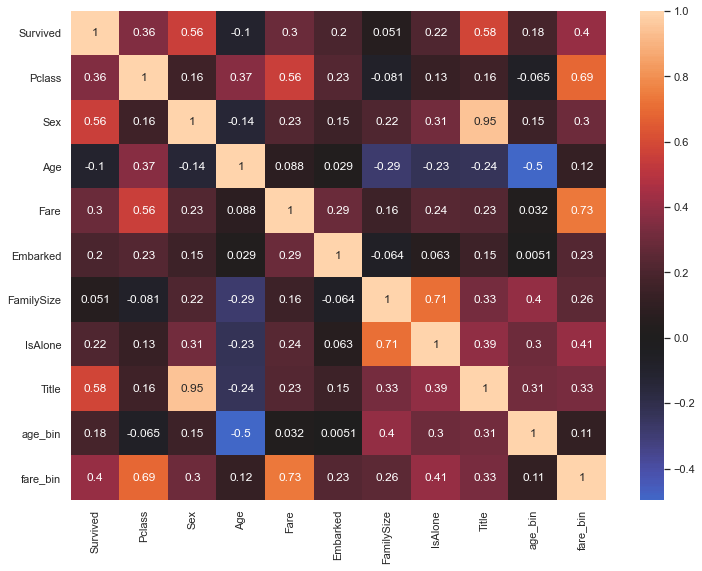

In [9]:
plt.figure(figsize = (12,9))
sns.heatmap(pd.concat([y_train, X_train], axis = 1).corr(), annot = True, center = 0);

Index(['Pclass', 'Sex', 'Fare', 'Title', 'fare_bin'], dtype='object')

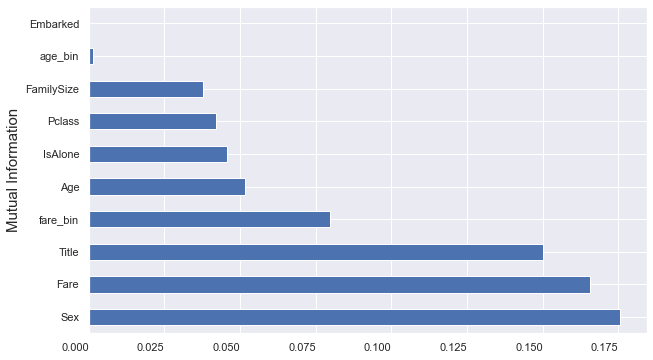

In [10]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

mi = mutual_info_classif(X_train, y_train)

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.barh(figsize=(10, 6));
plt.xticks(ha = 'right')
plt.ylabel('Mutual Information');

# select features
sel_ = SelectKBest(mutual_info_classif, k=5).fit(X_train, y_train)

# display features

mi_feat = X_train.columns[sel_.get_support()]
mi_feat

Index(['Pclass', 'Sex', 'Fare', 'Title', 'fare_bin'], dtype='object')

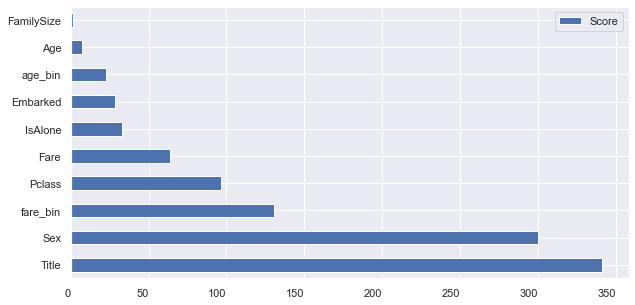

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif #or f_regression for regression. #ANOVA

sel_ = SelectKBest(f_classif, k=5).fit(X_train, y_train)
pd.DataFrame({'Score': sel_.scores_}, index=X_train.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5));
plt.xticks(ha='right');

anova_feat = X_train.columns[sel_.get_support()]
anova_feat

In [12]:
%%time
#BAckward Elimination

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

back = SFS(model, k_features=(1,10), forward=False, floating=False, scoring = 'f1', 
            cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

back.fit(X_train, y_train)

print() 
print(f'Best Score: {back.k_score_*100:.3f} %')
    
back.k_feature_names_


Best Score: 79.344 %
Wall time: 1min 16s


('Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Title', 'fare_bin')

In [13]:
%%time
#Forward Selection

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

front = SFS(model, k_features=(1,10), scoring = 'f1', forward=True, 
            floating=False, cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

front.fit(X_train, y_train)

print()    
print(f'Best Score: {front.k_score_*100:.3f} %')
    
front.k_feature_names_


Best Score: 79.923 %
Wall time: 1min 12s


('Pclass', 'Fare', 'FamilySize', 'Title', 'fare_bin')

In [14]:
%%time
#Bidirectional Elimination

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

bi = SFS(model, k_features=(1,10), scoring = 'f1', forward=True, 
         floating=True, cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

bi.fit(X_train, y_train)

print() 
print(f'Best Score: {bi.k_score_*100:.3f} %')
    
bi.k_feature_names_


Best Score: 79.923 %
Wall time: 3min 1s


('Pclass', 'Fare', 'FamilySize', 'Title', 'fare_bin')

,Features,Score
7,Title,0.309705
0,Pclass,0.070936
9,fare_bin,0.023610
8,age_bin,0.003829
4,Embarked,0.003014
1,Sex,0.001589
6,IsAlone,0.000349
3,Fare,-0.000835
2,Age,-0.001362
5,FamilySize,-0.009445


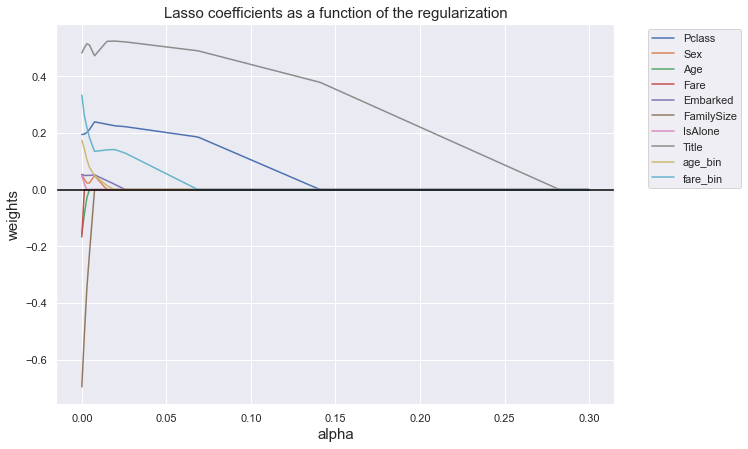

In [15]:
#Using LASSO regularization 

from sklearn import linear_model
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.linspace(-0.0,0.3,n_alphas)#10**np.linspace(10,-2,n_alphas)*0.5

coefs = []
for a in alphas:
    lasso = Pipeline(steps = [
        ('scaler', MinMaxScaler()), 
        ('lasso', linear_model.Lasso(alpha=a, fit_intercept=False))
    ])
    
    lasso.fit(X_train, y_train)
    coefs.append(lasso.named_steps.lasso.coef_)

# #############################################################################
# Display results
label = X_train.columns

plt.figure(figsize = (10,7))
ax = plt.gca()
ax.plot(alphas, coefs);

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(label, bbox_to_anchor=(1.05, 1), loc='upper left');

coef_df = pd.DataFrame({'Features': label, 'Score':np.mean(coefs,0)})

coef_df.sort_values('Score', ascending = False)

In [16]:
lasso_feat = ['Pclass', 'Embarked', 'Title', 'fare_bin']

Features ranked according to Extra Trees Feature Importance: Index(['Title', 'Sex', 'Fare', 'fare_bin', 'Age'], dtype='object')
Wall time: 190 ms


,Score
Pclass,0.096181
Sex,0.147796
Age,0.098920
Fare,0.142031
Embarked,0.021864
FamilySize,0.063064
IsAlone,0.012627
Title,0.258710
age_bin,0.049580
fare_bin,0.109227


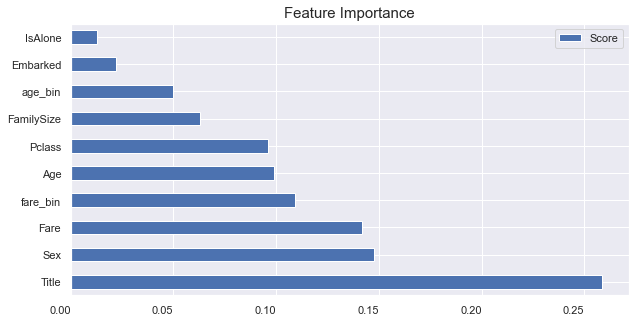

In [17]:
%%time

#Feature Importance

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

model.fit(X_train, y_train)

fi_df = pd.DataFrame({'Score': model.feature_importances_}, index=X_train.columns)

fi_df.sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5), 
                                                   title = 'Feature Importance');
plt.xticks(ha='right');

et_fi_feat = fi_df.sort_values('Score', ascending = False)[:5].index
print(f'Features ranked according to Extra Trees Feature Importance: {et_fi_feat}')

fi_df

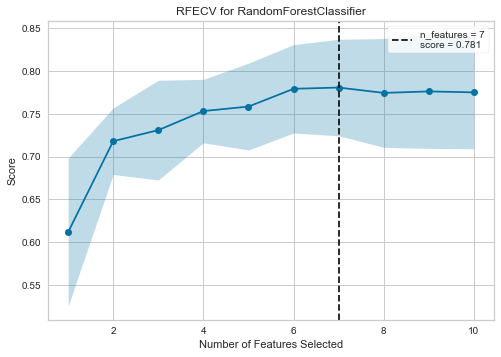

Feature Rankings: [1 1 1 1 3 1 4 1 2 1]
Wall time: 1min 20s


In [18]:
%%time

from yellowbrick.model_selection import RFECV

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

visualizer = RFECV(model, 
                   cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True), 
                   scoring = 'f1')

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure
   
print(f'Feature Rankings: {visualizer.ranking_}')

rfe_feat = [X_train.columns[i] for i, x in enumerate(visualizer.ranking_) if x==1]

Score when using all features: 77.714 %


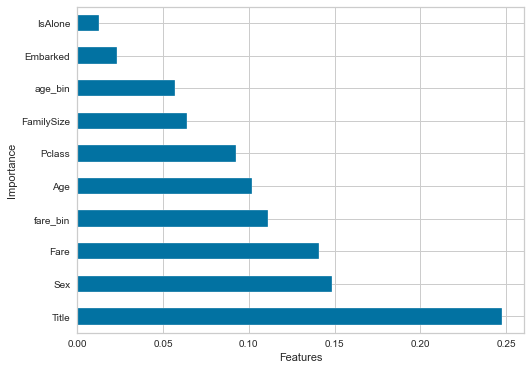

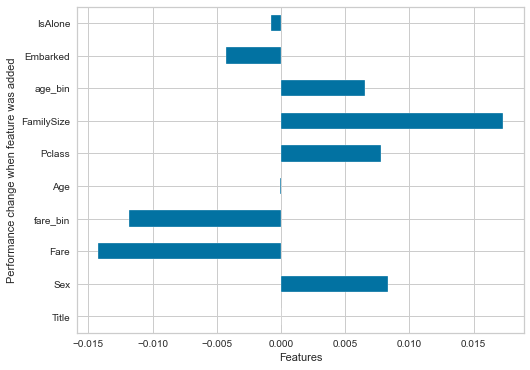

Selected Features: ['Pclass', 'Sex', 'FamilySize', 'Title', 'age_bin']
Wall time: 15.7 s


In [19]:
%%time

from feature_engine.selection import RecursiveFeatureAddition

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='f1',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=10,  # cross-validation
)

rfa.fit(X_train, y_train)

print(f'Score when using all features: {np.round(rfa.initial_model_performance_*100,3)} %')

# importance of all features based of initial model
rfa.feature_importances_.plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

pd.Series(rfa.performance_drifts_).plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

rfa_feat = [feat for feat in X_train.columns if feat not in rfa.features_to_drop_]

print(f'Selected Features: {rfa_feat}')

Score when using all features: 77.714 %


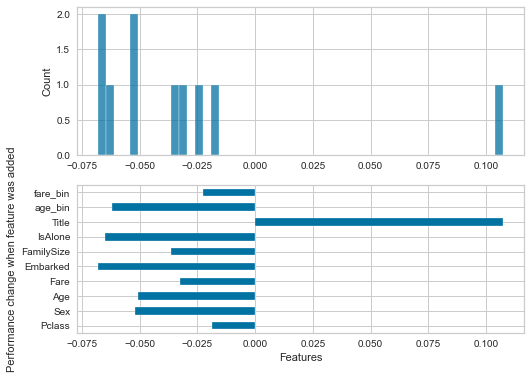

Selected Features: ['Pclass', 'Title', 'fare_bin']
Wall time: 3.35 s


In [20]:
%%time

from feature_engine.selection import SelectByShuffling

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

sel_shuff = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=model, # the ML model
    scoring='f1', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=10, # cross validation
    random_state=seed # seed
)

sel_shuff.fit(X_train, y_train)

print(f'Score when using all features: {np.round(sel_shuff.initial_model_performance_*100,3)} %')

fig, ax = plt.subplots(2,1)

sns.histplot(sel_shuff.performance_drifts_, bins = 50, ax=ax[0])

pd.Series(sel_shuff.performance_drifts_).plot.barh(figsize=(8,6));
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

sel_shuff_feat = [feat for feat in X_train.columns if feat not in sel_shuff.features_to_drop_]

print(f'Selected Features: {sel_shuff_feat}')

In [21]:
%%time
from boruta import BorutaPy

model = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state = seed)

feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=seed)

feat_selector.fit(X_train.values, y_train.Survived.values)

print(f'Selected Features: {feat_selector.support_}')
print()
print(f'Feature Ranking: {feat_selector.ranking_}')
print()
boruta_feat = [X_train.columns[i] for i, feat in enumerate(feat_selector.ranking_) if feat==1]
print(boruta_feat)

Selected Features: [ True  True  True  True False False False  True False  True]

Feature Ranking: [1 1 1 1 4 2 5 1 3 1]

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'fare_bin']
Wall time: 11.8 s


After performing all of the above feature selection techniques, I will save all of the feature selected varibales to a dictionary.

In [22]:
selected_features = {
    'mutual_information': mi_feat, 
    'ANOVA': anova_feat, 
    'back_elimination': list(back.k_feature_names_), 
#     'front_elimination': list(front.k_feature_names_),
    'bidirectional_elimination': list(bi.k_feature_names_),
    'LASSO_regularization': lasso_feat, 
    'Tree_feature_imp': et_fi_feat, 
    'recursive_feature_elimination': rfe_feat, 
    'recursive_feature_addition': rfa_feat, 
    'select_by_shuffle': sel_shuff_feat, 
    'Boruta': boruta_feat
}

In [23]:
selected_features

{'mutual_information': Index(['Pclass', 'Sex', 'Fare', 'Title', 'fare_bin'], dtype='object'),
 'ANOVA': Index(['Pclass', 'Sex', 'Fare', 'Title', 'fare_bin'], dtype='object'),
 'back_elimination': ['Sex',
  'Age',
  'Fare',
  'FamilySize',
  'IsAlone',
  'Title',
  'fare_bin'],
 'bidirectional_elimination': ['Pclass',
  'Fare',
  'FamilySize',
  'Title',
  'fare_bin'],
 'LASSO_regularization': ['Pclass', 'Embarked', 'Title', 'fare_bin'],
 'Tree_feature_imp': Index(['Title', 'Sex', 'Fare', 'fare_bin', 'Age'], dtype='object'),
 'recursive_feature_elimination': ['Pclass',
  'Sex',
  'Age',
  'Fare',
  'FamilySize',
  'Title',
  'fare_bin'],
 'recursive_feature_addition': ['Pclass',
  'Sex',
  'FamilySize',
  'Title',
  'age_bin'],
 'select_by_shuffle': ['Pclass', 'Title', 'fare_bin'],
 'Boruta': ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'fare_bin']}

In the next session, I have created a Function that will train all classififcation models on datasets that has the corresponding selected featurs for each iteration and then display only the top models for each feature selected variables as a dataframe.

In [24]:
def best_features(train_X, train_Y, feature_dict, preprocessor, cv):
    
    """
    A Function that will iterate over each feature selected variables and cross-validate all classification 
    models and display the results of only the top performing models with corresponding scores for each of 
    feature selected variables.
    """
    
    #Models that require scaling
    models = [
        LogisticRegression(random_state = seed),
        LogisticRegressionCV(cv=10, random_state = seed),
        SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
        Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
        PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
        RidgeClassifier(random_state = seed),
        RidgeClassifierCV(cv=10),
        LinearSVC(loss = 'hinge', random_state = seed),
        SVC(kernel = 'rbf', random_state = seed),
        NuSVC(random_state = seed),
        KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
        GaussianNB(), 
        BernoulliNB(),
        MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
        GaussianProcessClassifier(random_state = seed)
    ]
    
    #Models that dont require scaling
    tree_models = [
        DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = seed),
        RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
        XGBClassifier(use_label_encoder=False, eval_metric = 'error', seed = seed), 
        CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', random_seed = seed), 
        LGBMClassifier(random_state = seed), 
        AdaBoostClassifier(random_state = seed), 
        GradientBoostingClassifier(random_state = seed), 
        BaggingClassifier(random_state = seed), 
        ExtraTreesClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
        HistGradientBoostingClassifier(random_state = seed), 
        EasyEnsembleClassifier(random_state = seed), 
        RUSBoostClassifier(random_state = seed), 
        BalancedBaggingClassifier(random_state = seed), 
        BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6, random_state = seed, class_weight = 'balanced'), 
        RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
        FastRGFClassifier(loss='LOGISTIC'),
        GPBoostClassifier(random_state = seed)
    ]
    
    
    select = [] #Feature selected variable
    top_acc = []
    top_f1 = []
    top_roc_auc = []
    top_prec = []
    top_recall = []
    top_bal_acc = []
    top_model = []

    for name, feat, i in zip(feature_dict.keys(), 
                             feature_dict.values(), 
                             range(len(feature_dict.keys()))):
        
        Xtrain = train_X.loc[:,feat] #take only those features presen in the feature selected varibale
        ytrain = train_Y

        acc = []
        f1 = []
        roc_auc = []
        prec = []
        recall = []
        bal_acc = []
        model_names = []

        for model in models:
            pipe = Pipeline(steps = [('preprocessor', preprocessor), (type(model).__name__, model)])

            scores = cross_validate(pipe, 
                                    Xtrain, 
                                    ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = cv, 
                                    n_jobs = -1)

            acc.append(list(scores.values())[2].mean()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)

            model_names.append(type(model).__name__)

        #Using Ensemble Models
        for model in tree_models:

            scores = cross_validate(model, 
                                    Xtrain, 
                                    ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = cv, 
                                    n_jobs = -1)

            acc.append(list(scores.values())[2].mean()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            model_names.append(type(model).__name__)
        
        #compiling all scores of all models for that partiular feature selection.
        temp_df = pd.DataFrame({
            'Models': model_names, 
            'Acc %': acc, 
            'f1 %': f1,
            'ROC_AUC %' : roc_auc, 
            'Precision %': prec,
            'Recall %': recall, 
            'Balanced_Acc %': bal_acc 
        }).sort_values('f1 %', ascending = False, ignore_index = True)
        
        #Creating another dataframe which displays only the top performing model based on F1 score
        select.append(name)
        top_model.append(temp_df.iloc[0,0])
        top_acc.append(temp_df.iloc[0,1])
        top_f1.append(temp_df.iloc[0,2])
        top_roc_auc.append(temp_df.iloc[0,3])
        top_prec.append(temp_df.iloc[0,4])
        top_recall.append(temp_df.iloc[0,5])
        top_bal_acc.append(temp_df.iloc[0,6])
        
        Progress(i, len(feature_dict.keys()))
    print()

    df = pd.DataFrame({
        'Feature_Selection': select,
        'Model': top_model, 
        'Acc': top_acc, 
        'f1': top_f1,
        'ROC_AUC' : top_roc_auc, 
        'Prec': top_prec,
        'Recall': top_recall, 
        'Bal_Acc': top_bal_acc 
    }).sort_values('f1', ascending = False, ignore_index = True).style.\
                                                    highlight_max(color = 'green')
    
    return df

# best_features(train_X, train_Y, feature_dict, preprocessor, cv)

In [25]:
%%time

best_features(X_train, 
              y_train, 
              feature_dict = selected_features,
              preprocessor = preprocessor, 
              cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

Progress: [####################################################################################################]9/9 100.00%
Wall time: 10min 33s


,Feature_Selection,Model,Acc,f1,ROC_AUC,Prec,Recall,Bal_Acc
0,bidirectional_elimination,BalancedRandomForestClassifier,84.118046,80.536445,88.732958,76.301182,85.553846,84.397132
1,mutual_information,BalancedBaggingClassifier,84.726368,80.253131,88.123390,79.602824,81.261538,84.074439
2,ANOVA,BalancedBaggingClassifier,84.726368,80.253131,88.123390,79.602824,81.261538,84.074439
3,back_elimination,RandomForestClassifier,83.971054,79.343708,87.249942,78.242414,80.861538,83.389538
4,recursive_feature_elimination,BalancedRandomForestClassifier,82.921755,79.130041,88.177906,74.727532,84.369231,83.197972
5,Boruta,HistGradientBoostingClassifier,83.821800,78.202690,87.759305,80.370509,76.553846,82.446493
6,select_by_shuffle,DecisionTreeClassifier,84.138399,77.622067,88.497829,84.025677,72.261538,81.885705
7,Tree_feature_imp,RandomForestClassifier,81.130710,76.846100,85.658733,72.781946,81.630769,81.218985
8,recursive_feature_addition,GaussianProcessClassifier,83.530077,76.623655,86.421245,83.517585,71.061538,81.166658
9,LASSO_regularization,BalancedRandomForestClassifier,79.330620,75.522835,87.744447,69.189531,83.569231,80.135370


From the above dataframe, Bi-directinal elimination has the right features that gives the highest F1 score compared to all other features. <br>
<br>
It has to be noted that all of these score are only based on traning set. The only way to know whether these models have overfitted is through model validation, which is done in the next norebook after this.

In [26]:
#Saving datasets with only those features from the selected frature selection varibale.

X_train_pars = X_train.loc[:, bi.k_feature_names_]
X_test_pars = X_test.loc[:, bi.k_feature_names_]
TEST_DF_pars = TEST_DF.loc[:, bi.k_feature_names_]

In [28]:
%%time
all_models = classif_models(X_train_pars, 
                            y_train, 
                            preprocessor = preprocessor,
                            cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True))

all_models.check_clf_models()

Training using Non-Tree based models...
Progress: [####################################################################################################]14/14 100.00%

Training Using Ensemble models...
Progress: [####################################################################################################]16/16 100.00%
Wall time: 54.1 s


,Models,Acc %,Acc STD %,f1 %,ROC_AUC %,Precision %,Recall %,Balanced_Acc %
0,BalancedRandomForestClassifier,84.118046,4.253635,80.536445,88.732958,76.301182,85.553846,84.397132
1,RandomForestClassifier,84.120308,4.348962,79.922583,89.178379,77.855032,82.461538,83.826588
2,ExtraTreesClassifier,83.971054,4.440738,79.805646,88.636380,77.341777,82.815385,83.756705
3,CatBoostClassifier,85.031660,3.050059,79.750308,89.076030,83.015423,76.969231,83.513651
4,BalancedBaggingClassifier,84.276346,2.372187,79.613997,87.614455,78.966688,80.492308,83.573680
5,RGFClassifier,85.332429,4.749329,79.596309,89.034164,84.486797,75.800000,83.532985
6,XGBClassifier,84.579376,2.924961,79.261312,88.251389,81.480612,77.353846,83.218154
7,EasyEnsembleClassifier,82.919493,5.074256,79.021067,87.060431,74.986811,83.953846,83.112231
8,GradientBoostingClassifier,84.427861,4.399961,78.982434,88.868775,81.632459,76.923077,82.999866
9,LGBMClassifier,84.278607,4.029236,78.908315,88.570633,81.005125,77.369231,82.979040


In [27]:
X_train_pars.to_csv('X_train_pars.csv', index = False)
X_test_pars.to_csv('X_test_pars.csv', index = False)
TEST_DF_pars.to_csv('TEST_DF_pars.csv', index = False)